# **Human Activity Recognition Using the WISDM Dataset**

In this project, we aim to recognize human activities using the WISDM (Wireless Sensor Data Mining) dataset. We will load and clean the data, perform exploratory data analysis with visualizations and numerical summaries, and prepare the data for modeling. Throughout this process, we will add key insights to enhance our understanding and provide valuable observations for our analysis.

## **1. Data Loading and Cleaning**

### **1.1 Importing Necessary Libraries**

In [84]:
# Essential Libraries
import pandas as pd  # Data manipulation
import numpy as np  # Numerical computations
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns  # Advanced visualizations
import warnings  

# Preprocessing and Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import shuffle, class_weight
from scipy.interpolate import CubicSpline  

# TensorFlow/Keras for Deep Learning
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, MaxPooling1D, GRU, Dropout, Dense,
    MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Add,
    Bidirectional, LSTM
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore", category=DeprecationWarning)

### **1.2 Fixing the Raw Dataset**

In [2]:
# Define the paths to the datasets
dataset_path = 'WISDM_ar_v1.1_raw.txt'
fixed_dataset_path = 'WISDM_fixed.txt'

In [3]:
# Initialize counters for tracking fixes
total_lines = 0
fixed_lines = 0

In [4]:
# Open the raw dataset and create a new file for the fixed data
with open(dataset_path, 'r') as file, open(fixed_dataset_path, 'w') as fixed_file:
    for line in file:
        total_lines += 1
        # Clean the line
        line = line.strip().rstrip(';')  # Remove trailing semicolon
        if not line:
            continue  # Skip empty lines

        # Split into fields
        parts = line.split(',')

        # Check for missing or extra fields
        if len(parts) != 6:
            fixed_lines += 1
            # Add missing fields with placeholders or trim extra fields
            if len(parts) < 6:
                parts += ['0'] * (6 - len(parts))  # Placeholder for missing numeric values
            else:
                parts = parts[:6]

        # Validate and fix each field
        try:
            parts[0] = str(int(parts[0]))  # User ID
        except ValueError:
            fixed_lines += 1
            parts[0] = "0"  # Replace invalid User ID

        parts[1] = str(parts[1])  # Activity

        try:
            parts[2] = str(int(parts[2]))  # Timestamp
        except ValueError:
            fixed_lines += 1
            parts[2] = "0"  # Replace invalid timestamp

        for i in range(3, 6):
            try:
                parts[i] = str(float(parts[i]))  # Accelerations
            except ValueError:
                fixed_lines += 1
                parts[i] = "0.0"  # Replace invalid acceleration

        # Write the fixed line to the new file
        fixed_file.write(','.join(parts) + '\n')

In [5]:
# Report the number of lines processed and fixed
print(f"Total lines processed: {total_lines}")
print(f"Total lines fixed: {fixed_lines}")

Total lines processed: 1098210
Total lines fixed: 11744


- **Data Quality:** Out of **1,098,210** lines, **11,744** lines required fixing, indicating that approximately **1%** of the dataset had inconsistencies. Addressing these issues is crucial for ensuring the reliability of our subsequent analysis.

### **1.3 Loading the Fixed Data into a DataFrame**

- We load the cleaned data into a Pandas DataFrame for analysis.


In [6]:
# Define column names
column_names = ['user', 'activity', 'timestamp', 'x', 'y', 'z']

# Load the fixed data
data = pd.read_csv(fixed_dataset_path, header=None, names=column_names)

### **1.4 Saving the Cleaned Data**

- We save the cleaned DataFrame for future use to avoid reprocessing.


In [7]:
# Save the cleaned data to a CSV file
cleaned_csv_path = 'WISDM_cleaned.csv'
data.to_csv(cleaned_csv_path, index=False)
print("Data loaded, fixed, and saved successfully!")

Data loaded, fixed, and saved successfully!


## **2. Data Exploration**

### **2.1 Displaying Basic Information**

- We preview the dataset to understand its structure.



In [8]:
# Display the first few rows
print("First five rows of the dataset:")
print(data.head())

# Display dataset information
print("\nDataset Information:")
print(data.info())


First five rows of the dataset:
   user activity       timestamp         x          y         z
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x          1098204 non-null  float64
 4   y          1098204 non-null  float64
 5   z          1098204 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB
None


- **Dataset Size:** The dataset contains **1,098,204** entries with **6** columns: 'user', 'activity', 'timestamp', 'x', 'y', 'z'.
- **Data Types:** The 'user' and 'timestamp' columns are integers, 'activity' is an object (string), and 'x', 'y', 'z' are floats.
- **Completeness:** There are no missing values in any column, ensuring data integrity for analysis.


### **2.2 Exploring Class Distribution**

#### **Plotting Class Distribution**

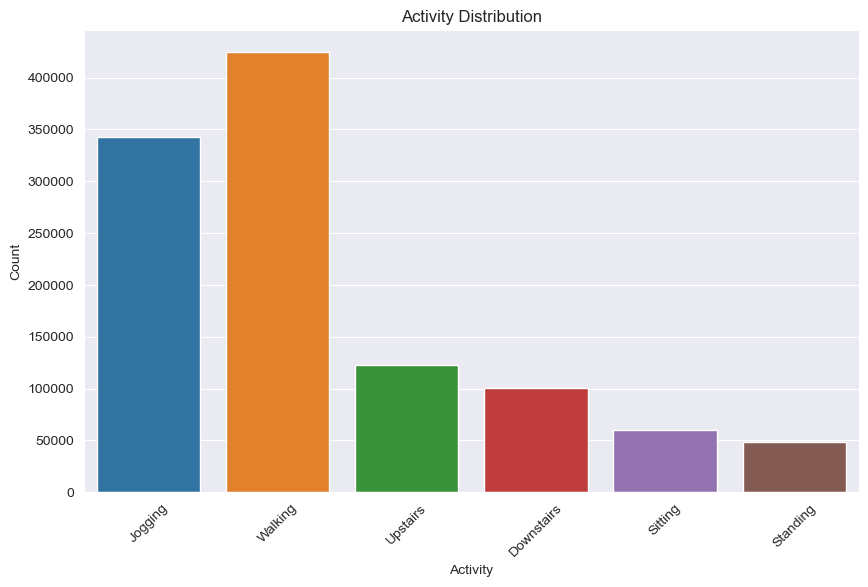

In [9]:
# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='activity', data=data)
plt.title('Activity Distribution')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### **Summary of Class Distribution**

In [10]:
# Calculate activity counts
activity_counts = data['activity'].value_counts()

# Calculate total number of samples
total_samples = data.shape[0]

# Calculate percentage for each activity
activity_percentages = (activity_counts / total_samples) * 100

# Create a summary DataFrame
activity_summary = pd.DataFrame({
    'Activity': activity_counts.index,
    'Count': activity_counts.values,
    'Percentage': activity_percentages.values
})

# Display the activity summary
print("Activity Summary with Percentages:")
print(activity_summary)

Activity Summary with Percentages:
     Activity   Count  Percentage
0     Walking  424398   38.644733
1     Jogging  342176   31.157781
2    Upstairs  122869   11.188176
3  Downstairs  100427    9.144658
4     Sitting   59939    5.457911
5    Standing   48395    4.406740


#### Observations
- **Class Imbalance:** 'Walking' and 'Jogging' together account for **766,574** samples, which is approximately **70%** of the dataset.
- **Minority Classes:** 'Upstairs', 'Downstairs', 'Sitting', and 'Standing' are underrepresented, making up the remaining **30%**.
- **Implication:** The significant class imbalance may affect model performance, favoring majority classes unless addressed.


### **2.3 Statistical Summaries of Accelerometer Readings**

#### **Plotting Histograms of Accelerometer Readings**

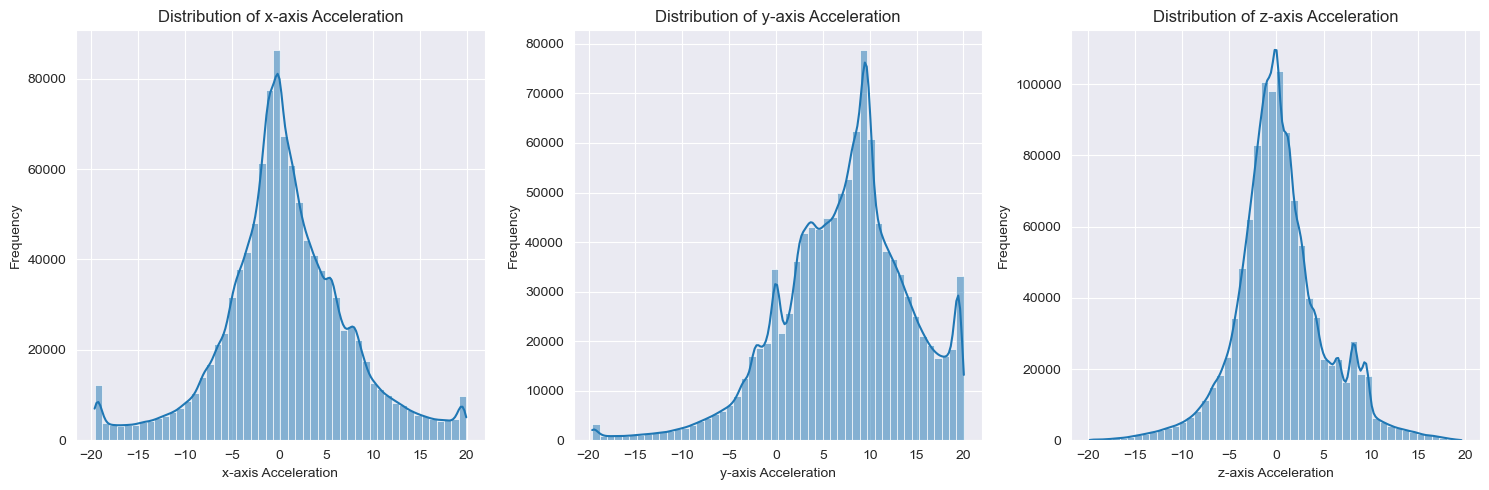

In [11]:
# Histograms of accelerometer readings
plt.figure(figsize=(15, 5))

for i, axis in enumerate(['x', 'y', 'z']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[axis], bins=50, kde=True)
    plt.title(f'Distribution of {axis}-axis Acceleration')
    plt.xlabel(f'{axis}-axis Acceleration')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### **Numerical Summaries of Accelerometer Readings**

In [12]:
# Statistical summaries
stats_summary = data[['x', 'y', 'z']].describe().T

# Display statistical summaries
print("Statistical Summary of Accelerometer Readings:")
print(stats_summary)

Statistical Summary of Accelerometer Readings:
       count      mean       std    min   25%   50%    75%    max
x  1098204.0  0.662868  6.849058 -19.61 -2.87  0.27   4.44  19.95
y  1098204.0  7.255639  6.746204 -19.61  3.17  7.93  11.56  20.04
z  1098204.0  0.411058  4.754102 -19.80 -2.22  0.00   2.72  19.61


#### Observations
- **Mean Values:**
  - The **y-axis** has a higher mean (**7.26**), suggesting the phone's orientation during data collection was such that the y-axis was aligned with gravity.
  - The **x-axis** and **z-axis** have lower mean values (**0.66** and **0.41**), indicating less influence from gravity.
- **Variability:**
  - The **standard deviations** indicate considerable variability in acceleration readings across all axes.
- **Range of Values:**
  - Acceleration values range from approximately **-20** to **+20** units on all axes, reflecting diverse movement.


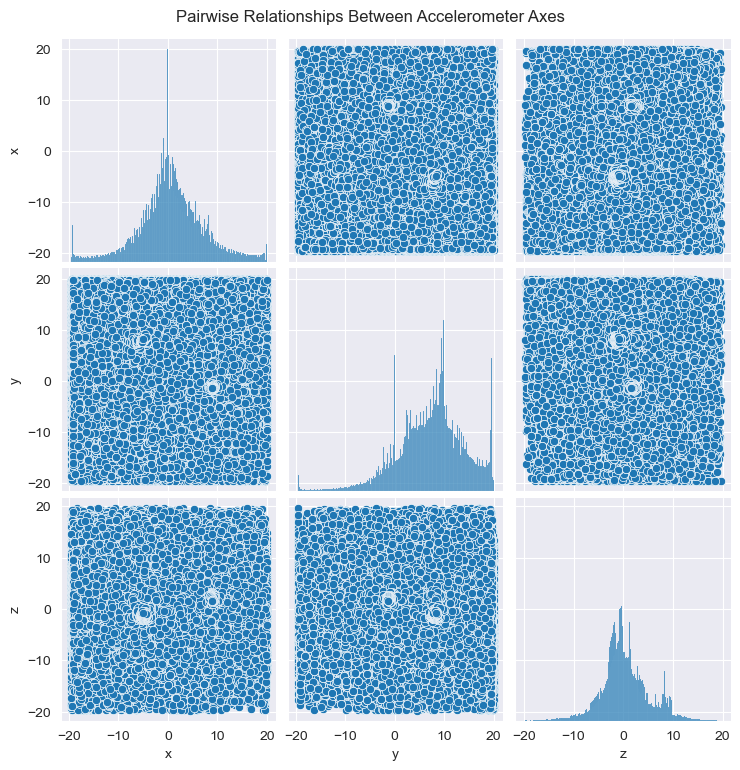

In [13]:
# Pairplot of accelerometer readings
sns.pairplot(data[['x', 'y', 'z']])
plt.suptitle('Pairwise Relationships Between Accelerometer Axes', y=1.02)
plt.show()

### **2.4 Correlation Between Accelerometer Axes**

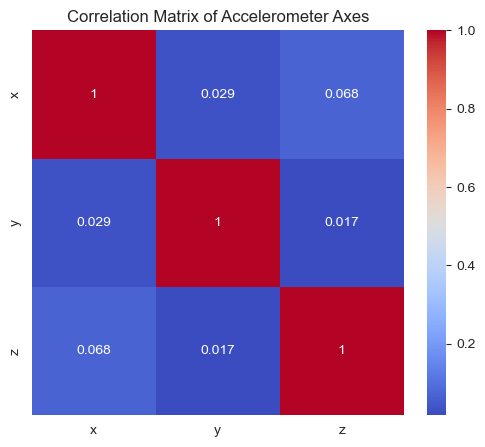

In [14]:
# Correlation matrix
corr_matrix = data[['x', 'y', 'z']].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Accelerometer Axes')
plt.show()


In [15]:
# Display correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
          x         y         z
x  1.000000  0.029126  0.067996
y  0.029126  1.000000  0.017383
z  0.067996  0.017383  1.000000


#### Observations
- **Low Correlation:** The correlation coefficients between axes are low (less than **0.1**), indicating that the accelerations along each axis are largely independent.
- **Implication:** Each axis contributes unique information, which is beneficial for distinguishing between activities.


### **2.5 Visualizing Accelerometer Readings Over Time for Each Activity**

#### **Plotting Accelerometer Readings Over Time**

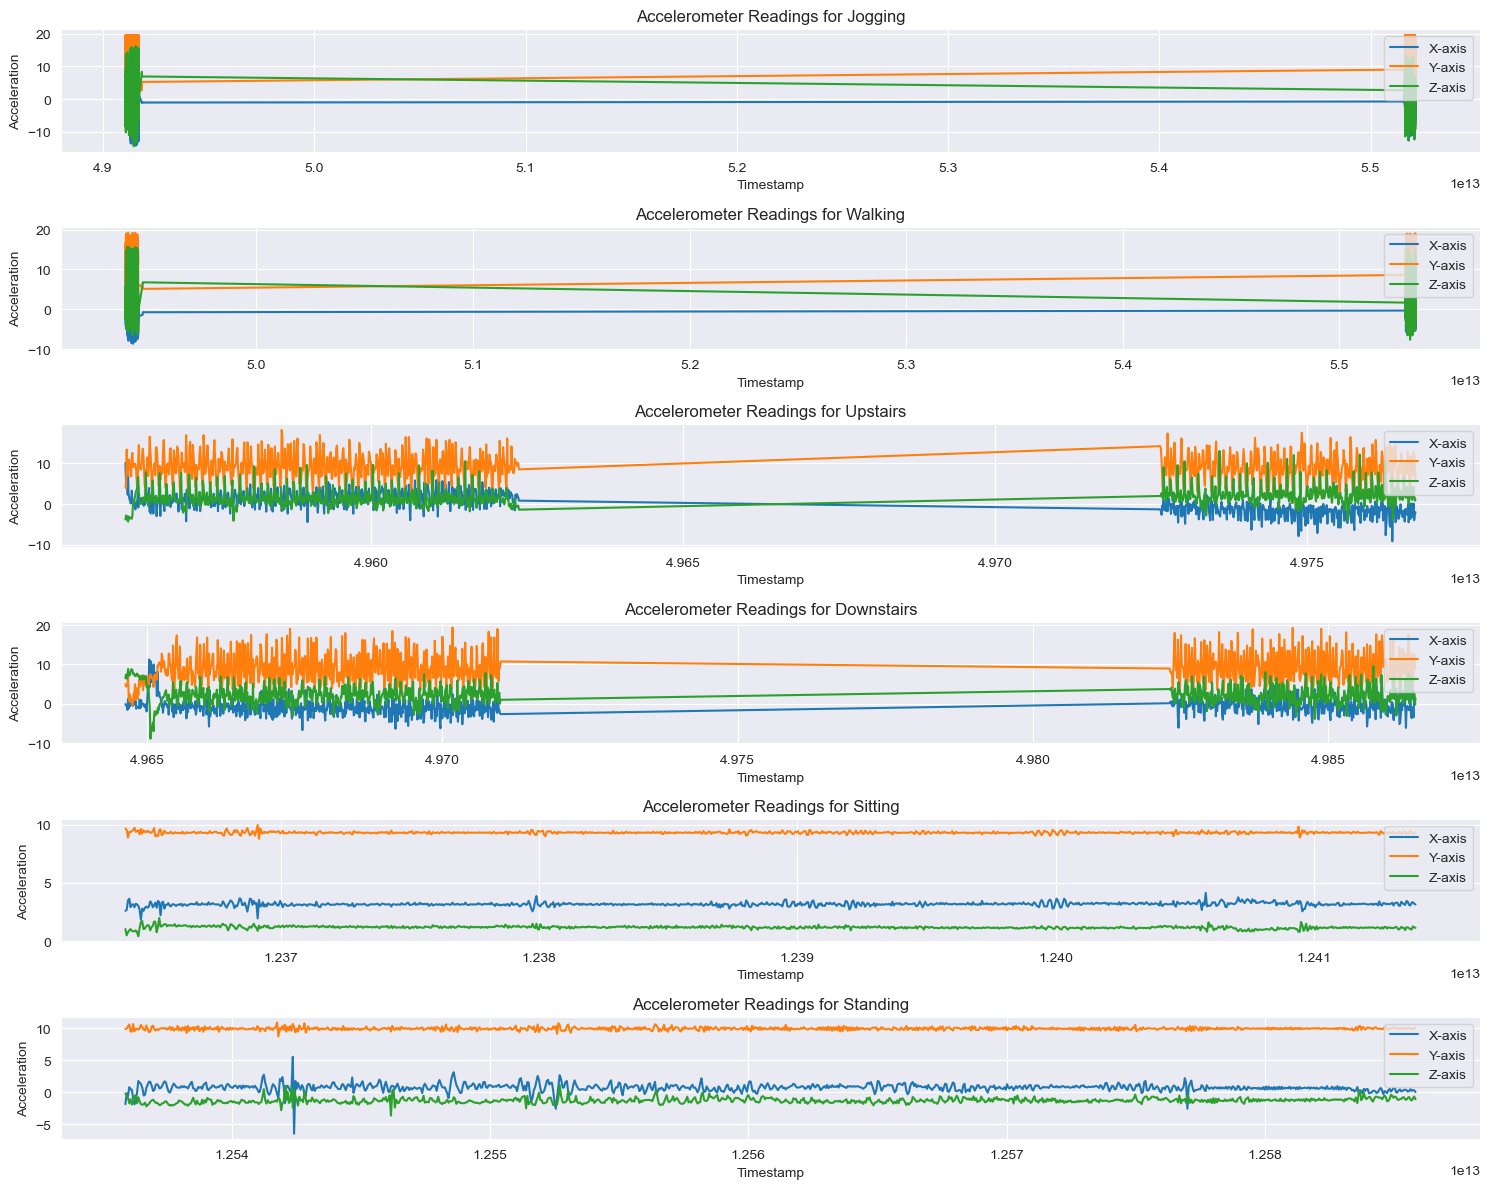

In [16]:
# Sample data for each activity
activities = data['activity'].unique()
plt.figure(figsize=(15, 12))

for i, activity in enumerate(activities):
    plt.subplot(len(activities), 1, i+1)
    activity_data = data[data['activity'] == activity].head(1000)  # Limiting to 1000 samples for plotting
    plt.plot(activity_data['timestamp'], activity_data['x'], label='X-axis')
    plt.plot(activity_data['timestamp'], activity_data['y'], label='Y-axis')
    plt.plot(activity_data['timestamp'], activity_data['z'], label='Z-axis')
    plt.title(f'Accelerometer Readings for {activity}')
    plt.xlabel('Timestamp')
    plt.ylabel('Acceleration')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### **Summary of Accelerometer Readings Over Time**

In [17]:
# Mean accelerations per activity
mean_per_activity = data.groupby('activity')[['x', 'y', 'z']].mean()

# Standard deviation per activity
std_per_activity = data.groupby('activity')[['x', 'y', 'z']].std()

# Display mean accelerations per activity
print("Mean Accelerometer Readings per Activity:")
print(mean_per_activity)

# Display standard deviation per activity
print("\nStandard Deviation of Accelerometer Readings per Activity:")
print(std_per_activity)

Mean Accelerometer Readings per Activity:
                   x         y         z
activity                                
Downstairs  0.471718  8.600230  0.684074
Jogging    -0.201981  5.461138 -0.124315
Sitting     1.856270  1.853374  6.559716
Standing   -1.178258  8.987236  0.580115
Upstairs    0.381334  8.111545  0.323542
Walking     1.528303  8.702026 -0.084231

Standard Deviation of Accelerometer Readings per Activity:
                   x         y         z
activity                                
Downstairs  4.955948  4.904716  3.706747
Jogging     9.109505  9.224966  5.833207
Sitting     4.759028  3.257750  3.735591
Standing    3.235125  1.264772  1.376795
Upstairs    5.495272  4.890709  3.567884
Walking     5.793337  5.006498  4.011056


- **Dynamic vs. Static Activities:**
  - **Dynamic activities** like 'Jogging' and 'Walking' have higher standard deviations, indicating greater variability in acceleration due to movement.
  - **Static activities** like 'Sitting' and 'Standing' have lower standard deviations, reflecting minimal movement.
- **Mean Accelerations:**
  - 'Sitting' has a higher mean on the **z-axis**, likely due to the phone's orientation when seated.
  - 'Standing' and 'Walking' show higher mean values on the **y-axis**, consistent with upright posture.
- **Implication:** These differences in mean and variability are crucial for distinguishing between activities in the modeling phase.


## **3. Data Preprocessing**

### **3.1 Feature Normalization**
- We normalize the accelerometer readings to have zero mean and unit variance.
- Normalization ensures that all features contribute equally to the model training, improving convergence and performance.

In [18]:

# Features to normalize
features = ['x', 'y', 'z']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
data[features] = scaler.fit_transform(data[features])

#### Plotting After Normalization

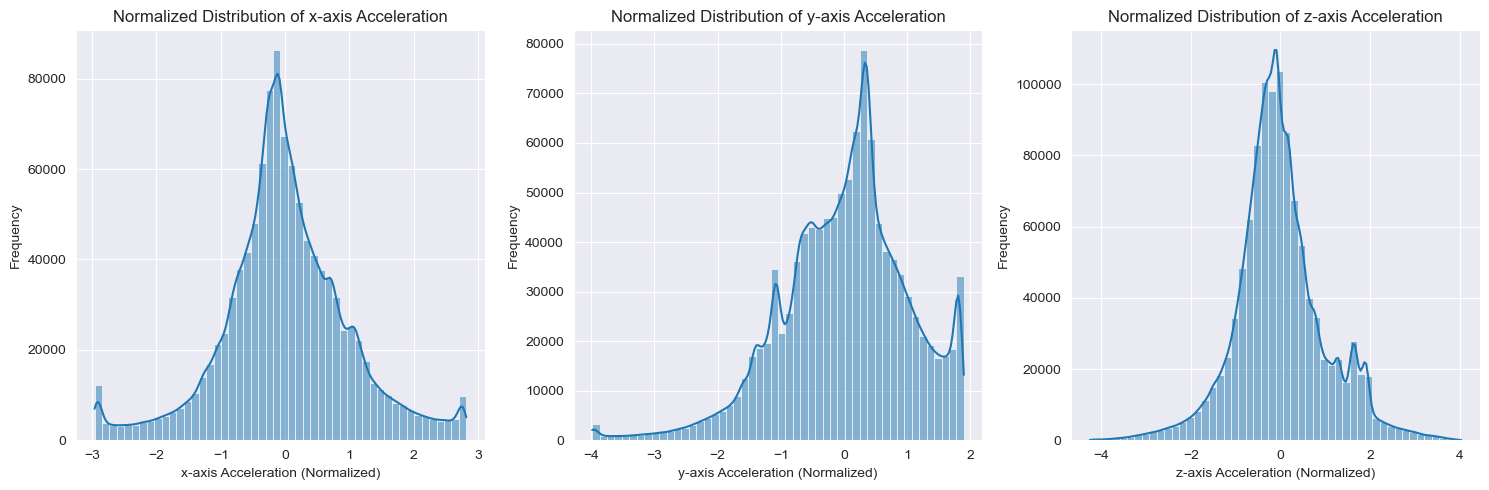

In [19]:
# Histograms of normalized accelerometer readings
plt.figure(figsize=(15, 5))

for i, axis in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[axis], bins=50, kde=True)
    plt.title(f'Normalized Distribution of {axis}-axis Acceleration')
    plt.xlabel(f'{axis}-axis Acceleration (Normalized)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [20]:
# Statistical summaries after normalization
normalized_stats_summary = data[features].describe().T

# Display statistical summaries after normalization
print("Statistical Summary of Normalized Accelerometer Readings:")
print(normalized_stats_summary)

Statistical Summary of Normalized Accelerometer Readings:
       count          mean  std       min       25%       50%       75%  \
x  1098204.0  2.215343e-17  1.0 -2.959951 -0.515818 -0.057361  0.551482   
y  1098204.0 -2.113893e-16  1.0 -3.982336 -0.605621  0.099962  0.638042   
z  1098204.0  5.031106e-17  1.0 -4.251290 -0.553429 -0.086464  0.485674   

        max  
x  2.816028  
y  1.895046  
z  4.038397  


- **Normalization Effectiveness:** The mean of each axis is approximately zero, and the standard deviation is one, confirming successful normalization.

### **3.2. Mapping Activity Labels to Integers**

We map the activity labels to numerical codes for **model compatibility.**


In [21]:
# Map activity labels to integers
activity_mapping = {
    'Walking': 0,
    'Jogging': 1,
    'Upstairs': 2,
    'Downstairs': 3,
    'Sitting': 4,
    'Standing': 5
}

data['activity_code'] = data['activity'].map(activity_mapping)

### **3.3. Sequence Creation**

**Purpose:** Segment the data into sequences to capture temporal patterns essential for time-series analysis.


In [22]:
# Define window size and step size
TIME_STEPS = 90
STEP = 45  # 50% overlap

# Define the features to be used
features = ['x', 'y', 'z']

def create_sequences(data, time_steps, step):
    sequences = []
    labels = []
    for start in range(0, len(data) - time_steps, step):
        end = start + time_steps
        sequences.append(data[features].values[start:end])
        # Use the label of the last time step in the window
        labels.append(data['activity_code'].values[end - 1])
    return sequences, labels

# Apply the function to the dataset
X = []
y = []

for user_id in data['user'].unique():
    user_data = data[data['user'] == user_id]
    for activity in user_data['activity'].unique():
        activity_data = user_data[user_data['activity'] == activity]
        sequences, labels = create_sequences(activity_data, TIME_STEPS, STEP)
        X.extend(sequences)
        y.extend(labels)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Display sequence information
print(f"Number of sequences created: {X.shape[0]}")
print(f"Sequence shape: {X.shape[1:]} (Time steps, Features)")

Number of sequences created: 24133
Sequence shape: (90, 3) (Time steps, Features)


- **Sequence Generation:** A total of **24,133** sequences were created, each containing **90** time steps and **3** features.
- **Overlap Strategy:** Using a **50%** overlap helps increase the number of training samples and captures more temporal dynamics.


### **3.4 Label Encoding**

We convert activity labels into one-hot encoded vectors suitable for multi-class classification.


In [23]:


# One-hot encode labels
y_encoded = to_categorical(y)
num_classes = y_encoded.shape[1]
print(f"Number of classes after encoding: {num_classes}")

Number of classes after encoding: 6


### **3.5 Data Splitting**

#### **Splitting the Data**

- We split the data into training and testing sets while maintaining class distribution.


In [24]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Display shapes of the splits
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (19306, 90, 3)
Testing set shape: (4827, 90, 3)


- **Training and Testing Sets:** The data is split into **19,306** training sequences and **4,827** testing sequences.
- **Stratification:** Stratifying ensures that the class distribution remains consistent across training and testing sets.


### **3.6 Class Weighting**
#### **Calculating Class Weights**
- We compute class weights to address class imbalance during model training.


In [25]:

# Convert one-hot labels back to integers
y_train_integers = np.argmax(y_train, axis=1)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)

class_weights_dict = {i: class_weights[i] for i in range(num_classes)}

# Display class weights
print("Class Weights:")
print(class_weights_dict)

Class Weights:
{0: 0.4288506819494424, 1: 0.5322856355114419, 2: 1.5000777000777001, 3: 1.8418240793741651, 4: 3.105855855855856, 5: 3.876706827309237}


- **Adjusting for Imbalance:** Higher weights are assigned to minority classes to emphasize them during training.
- **Impact on Model Training:** Class weighting helps prevent the model from being biased toward majority classes, improving performance on underrepresented activities.


## **4. Model Development and Training**

In this section, we build, train, and evaluate a deep learning model for Human Activity Recognition using the preprocessed data.

### **4.1 Building the CNN-GRU-Attention Model**

**Purpose:**

- **Convolutional Neural Networks (CNN):** Used for feature extraction from the input sequences.
- **Gated Recurrent Units (GRU):** Capture temporal dependencies in the data.
- **Attention Mechanism:** Focuses on the most relevant parts of the sequence.
- **Overall Goal:** Combine the strengths of CNN, GRU, and Attention to improve classification performance.


#### **Model Architecture:**

In [26]:
# Define the input layer
inputs = Input(shape=(TIME_STEPS, len(features)))

# CNN layers for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# GRU layers for capturing temporal dependencies
x = GRU(units=64, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = GRU(units=32, return_sequences=True)(x)
x = Dropout(0.5)(x)

# Attention mechanism to focus on important time steps
attention_output = MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
attention_output = GlobalAveragePooling1D()(attention_output)

# Output layer for classification
outputs = Dense(units=num_classes, activation='softmax')(attention_output)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 3)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 88, 64)       640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 88, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 44, 64)       0           ['batch_normalization[0][0]']

- **Model Complexity:** The model has **39,686** parameters, which is relatively lightweight and suitable for training on the dataset without overfitting.
- **Layer Functions:**
  - **Conv1D Layer:** Extracts local patterns in the data sequences.
  - **Batch Normalization:** Stabilizes and accelerates training.
  - **GRU Layers:** Capture sequential dependencies, essential for time-series data.
  - **Attention Mechanism:** Allows the model to focus on important time steps, enhancing performance.
- **Output Layer:** Uses a softmax activation function suitable for multi-class classification.


### **4.2 Training the Model**
- We train the model using the training data, applying early stopping to prevent overfitting and saving the best model during training.

In [27]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
302/302 [==============================] - 16s 22ms/step - loss: 0.6008 - accuracy: 0.7619 - val_loss: 0.4340 - val_accuracy: 0.8310
Epoch 2/50
302/302 [==============================] - 6s 19ms/step - loss: 0.2478 - accuracy: 0.9189 - val_loss: 0.1560 - val_accuracy: 0.9492
Epoch 3/50
302/302 [==============================] - 6s 19ms/step - loss: 0.1502 - accuracy: 0.9565 - val_loss: 0.0957 - val_accuracy: 0.9695
Epoch 4/50
302/302 [==============================] - 6s 19ms/step - loss: 0.1129 - accuracy: 0.9668 - val_loss: 0.0706 - val_accuracy: 0.9791
Epoch 5/50
302/302 [==============================] - 6s 19ms/step - loss: 0.0892 - accuracy: 0.9735 - val_loss: 0.0755 - val_accuracy: 0.9776
Epoch 6/50
302/302 [==============================] - 6s 20ms/step - loss: 0.0751 - accuracy: 0.9778 - val_loss: 0.0581 - val_accuracy: 0.9824
Epoch 7/50
302/302 [==============================] - 6s 19ms/step - loss: 0.0642 - accuracy: 0.9804 - val_loss: 0.0810 - val_accuracy: 0.976

In [28]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9964
Test Accuracy: 0.9867


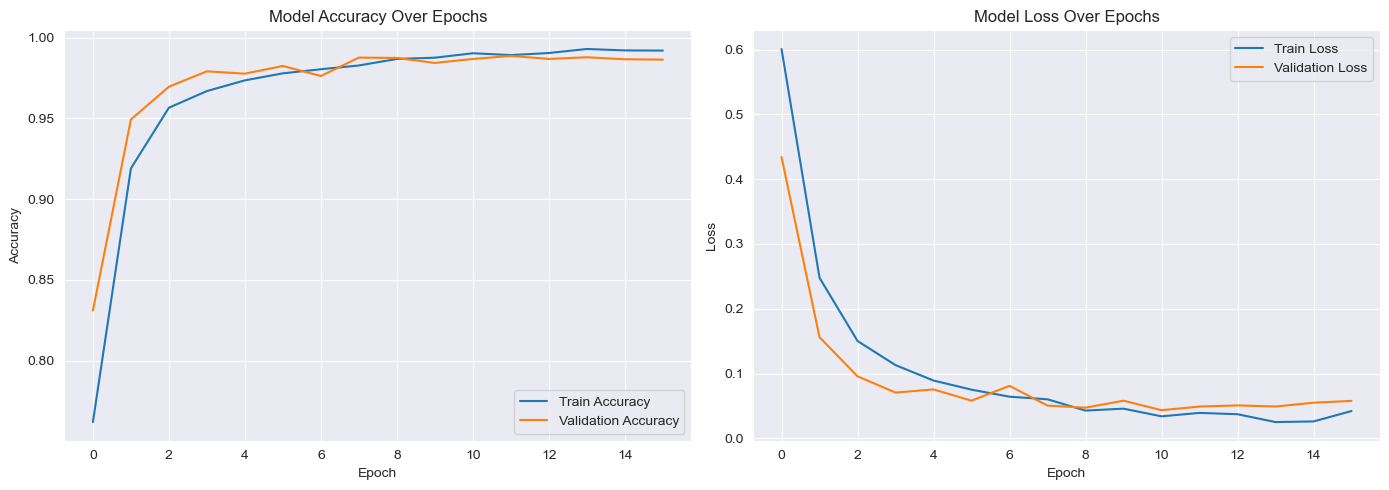

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

151/151 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

     Walking       0.99      0.99      0.99      1876
     Jogging       1.00      0.99      1.00      1511
    Upstairs       0.97      0.96      0.96       537
  Downstairs       0.96      0.96      0.96       437
     Sitting       1.00      0.98      0.99       259
    Standing       0.97      1.00      0.99       207

    accuracy                           0.99      4827
   macro avg       0.98      0.98      0.98      4827
weighted avg       0.99      0.99      0.99      4827


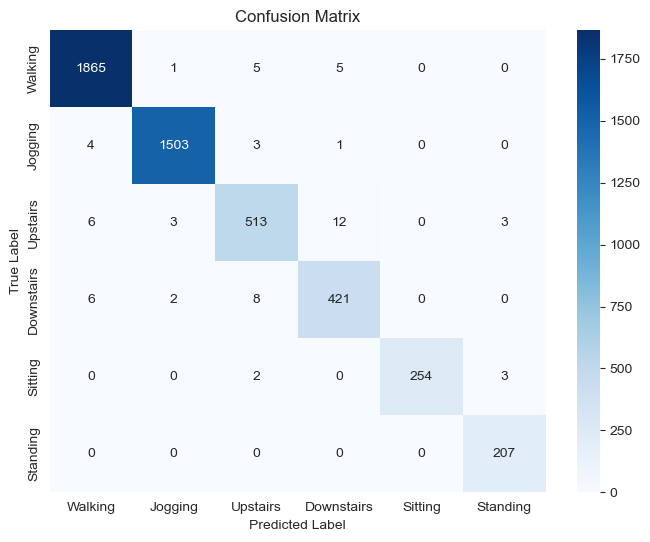

In [30]:
# Predict labels on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true, y_pred_classes, target_names=activity_mapping.keys(), output_dict=True)
print(classification_report(y_true, y_pred_classes, target_names=activity_mapping.keys()))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.keys(), yticklabels=activity_mapping.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## **5. Hyperparameter Tuning**
In this section, we perform hyperparameter tuning to optimize our model's performance by finding the best combination of parameters. Hyperparameter tuning helps in enhancing the model's accuracy and generalization by adjusting parameters that govern the learning process.

### **5.1 Purpose of Hyperparameter Tuning**

**Why Tune Hyperparameters?**

- **Model Performance:** Finding the optimal hyperparameters can significantly improve model accuracy and reduce overfitting.
- **Generalization:** Well-tuned models generalize better to unseen data.
- **Efficiency:** Optimal hyperparameters can reduce training time and computational resources.

**Key Hyperparameters to Tune:**

- **Optimizer:** Algorithm used to update network weights (e.g., 'adam', 'rmsprop').
- **Learning Rate:** Determines the step size during weight updates.
- **Dropout Rate:** Fraction of input units to drop to prevent overfitting.
- **Units in GRU Layers:** Number of neurons in the GRU layers, affecting model capacity.
- **Batch Size:** Number of samples processed before the model is updated.
- **Epochs:** Number of complete passes through the training dataset.


### **5.2 Building a Keras Classifier**
- We wrap our Keras model using `KerasClassifier` to make it compatible with scikit-learn's `RandomizedSearchCV` for hyperparameter tuning.

In [31]:

def create_model(optimizer='adam', dropout_rate=0.5, units=64):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, len(features))))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GRU(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units//2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

### **5.3 Defining Hyperparameter Space**

We define a range of hyperparameters to search over to find the best model configuration.


In [32]:
# Define the hyperparameter space
param_dist = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5, 0.7],
    'units': [32, 64, 128],
    'epochs': [10],          # Keeping epochs small for quicker searches
    'batch_size': [64, 128]
}

### **5.4 Performing Randomized Search**
We use `RandomizedSearchCV` to efficiently search through the hyperparameter space

In [33]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,   # Number of parameter settings sampled
    cv=3,       # 3-fold cross-validation
    verbose=1
)

In [34]:
# Perform the search
random_search_result = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [35]:
# Output the best parameters
print("Best Score: {:.4f} using {}".format(random_search_result.best_score_, random_search_result.best_params_))
best_params = random_search_result.best_params_

Best Score: 0.9727 using {'units': 128, 'optimizer': 'adam', 'epochs': 10, 'dropout_rate': 0.5, 'batch_size': 64}


- **Best Parameters Identified:** The optimal configuration uses `adam` optimizer, a dropout rate of **0.5**, **64** units, and a batch size of **64**.
- **Performance:** The cross-validated accuracy is approximately **0.9717%**, indicating a promising model configuration.

### **5.5 Retraining the Model with Best Parameters**

We rebuild and train the model using the best hyperparameters found during the search to improve performance.


In [36]:
# Rebuild the model with the best parameters
model = create_model(
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    units=best_params['units']
)

# Train the model
history_tuned = model.fit(
    X_train, y_train,
    epochs=50,  
    batch_size=best_params['batch_size'],
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
302/302 [==============================] - 9s 20ms/step - loss: 0.8002 - accuracy: 0.6478 - val_loss: 0.6038 - val_accuracy: 0.7584
Epoch 2/50
302/302 [==============================] - 7s 22ms/step - loss: 0.4678 - accuracy: 0.8233 - val_loss: 0.3335 - val_accuracy: 0.8749
Epoch 3/50
302/302 [==============================] - 5s 17ms/step - loss: 0.3163 - accuracy: 0.8903 - val_loss: 0.2694 - val_accuracy: 0.9030
Epoch 4/50
302/302 [==============================] - 6s 20ms/step - loss: 0.2178 - accuracy: 0.9270 - val_loss: 0.1557 - val_accuracy: 0.9501
Epoch 5/50
302/302 [==============================] - 6s 20ms/step - loss: 0.1758 - accuracy: 0.9457 - val_loss: 0.1222 - val_accuracy: 0.9617
Epoch 6/50
302/302 [==============================] - 5s 18ms/step - loss: 0.1535 - accuracy: 0.9557 - val_loss: 0.1058 - val_accuracy: 0.9679
Epoch 7/50
302/302 [==============================] - 5s 18ms/step - loss: 0.1243 - accuracy: 0.9636 - val_loss: 0.1338 - val_accuracy: 0.9557

#### **Evaluating Training Performance:**

In [37]:
# Evaluate the model on the training data
train_loss_tuned, train_accuracy_tuned = model.evaluate(X_train, y_train, verbose=0)
print(f"Tuned Training Accuracy: {train_accuracy_tuned:.4f}")

# Evaluate the model on the test data
test_loss_tuned, test_accuracy_tuned = model.evaluate(X_test, y_test, verbose=0)
print(f"Tuned Test Accuracy: {test_accuracy_tuned:.4f}")

Tuned Training Accuracy: 0.9974
Tuned Test Accuracy: 0.9907


- **Generalization:** The model generalizes well, as indicated by the high test accuracy.

#### **5.5.1 Visualizing Training Performance**

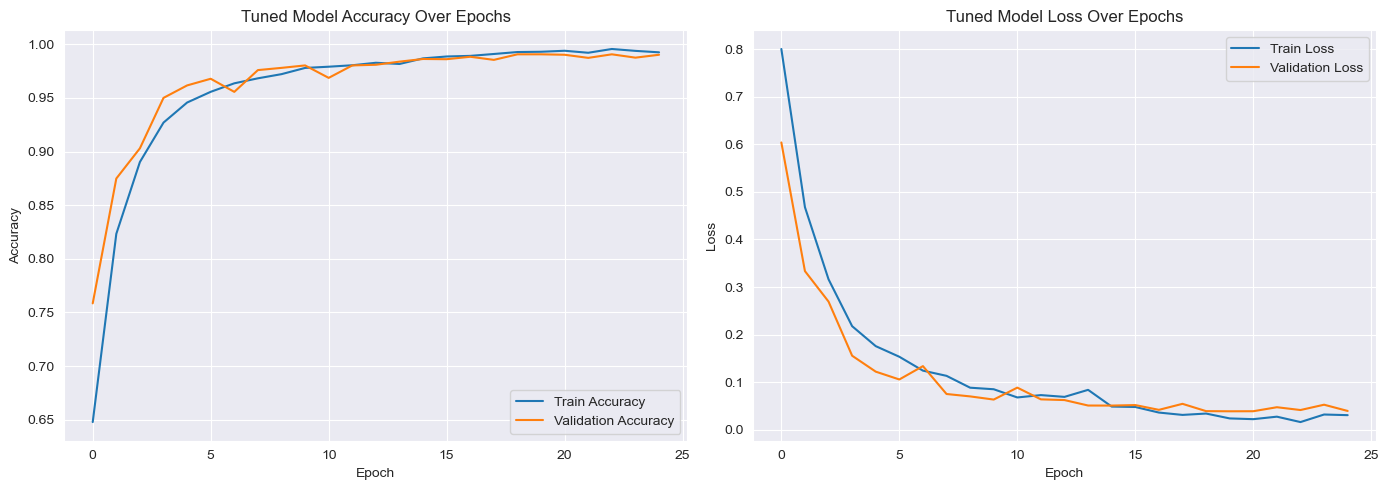

In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_tuned.history['accuracy'], label='Train Accuracy')
plt.plot(history_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_tuned.history['loss'], label='Train Loss')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss')
plt.title('Tuned Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### **5.6 Evaluating the Tuned Model**

In [39]:
# Predict labels on the test set
y_pred_tuned = model.predict(X_test)
y_pred_classes_tuned = np.argmax(y_pred_tuned, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate a classification report
report_tuned = classification_report(y_true, y_pred_classes_tuned, target_names=activity_mapping.keys(), output_dict=True)
print(classification_report(y_true, y_pred_classes_tuned, target_names=activity_mapping.keys()))

151/151 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00      1876
     Jogging       1.00      1.00      1.00      1511
    Upstairs       0.97      0.96      0.97       537
  Downstairs       0.96      0.98      0.97       437
     Sitting       1.00      0.99      0.99       259
    Standing       0.98      1.00      0.99       207

    accuracy                           0.99      4827
   macro avg       0.98      0.99      0.99      4827
weighted avg       0.99      0.99      0.99      4827


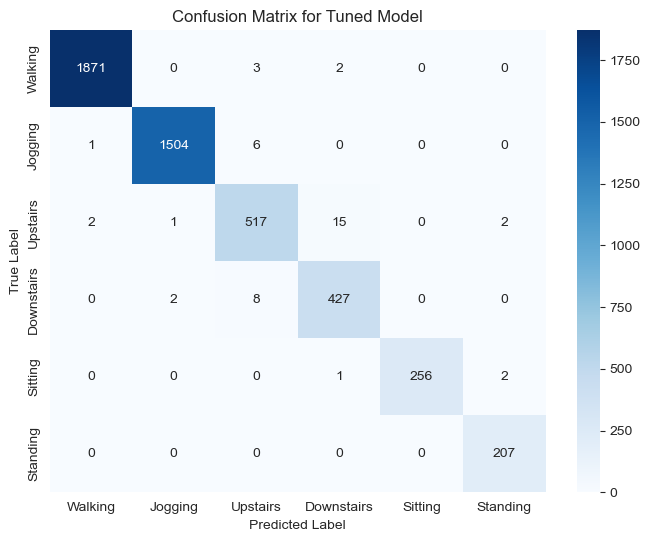

In [40]:
# Compute the confusion matrix
cm_tuned = confusion_matrix(y_true, y_pred_classes_tuned)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.keys(), yticklabels=activity_mapping.keys())
plt.title('Confusion Matrix for Tuned Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## **6. Data Augmentation**

In this section, we apply data augmentation techniques to address class imbalance and improve the model's performance on minority classes. Data augmentation can help the model generalize better and perform more accurately on underrepresented classes.


### **6.1 Identifying Minority Classes**

Before applying augmentation, we need to identify the classes that are underrepresented.


In [41]:
threshold = activity_counts.mean()

# Identify minority classes
minority_classes = activity_counts[activity_counts < threshold].index.tolist()
print("Minority Classes:", minority_classes)

# Map minority classes to their integer codes
minority_class_codes = [activity_mapping[act] for act in minority_classes]
print("Minority Class Codes:", minority_class_codes)

Minority Classes: ['Upstairs', 'Downstairs', 'Sitting', 'Standing']
Minority Class Codes: [2, 3, 4, 5]


### **6.2 Defining Augmentation Functions**

In [42]:

def add_noise(data_sequence, noise_factor=0.005):
    """Add random Gaussian noise to the data."""
    noise = np.random.randn(*data_sequence.shape) * noise_factor
    return data_sequence + noise

def scale_data(data_sequence, scaling_factor=0.1):
    """Randomly scale the data."""
    scaling = np.random.uniform(1 - scaling_factor, 1 + scaling_factor)
    return data_sequence * scaling

def time_mask(data_sequence, mask_ratio=0.1):
    """Randomly mask a portion of the data."""
    data_copy = data_sequence.copy()
    n_mask = int(data_sequence.shape[0] * mask_ratio)
    n_mask = max(n_mask, 1)
    mask_indices = np.random.choice(data_sequence.shape[0], n_mask, replace=False)
    data_copy[mask_indices] = 0
    return data_copy

def time_warp(data_sequence, sigma=0.2, knot=4):
    """Apply time warping to the data sequence."""
    orig_steps = np.arange(data_sequence.shape[0])
    random_warp = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2))
    warp_steps = np.linspace(0, data_sequence.shape[0]-1, num=knot+2)
    warper = CubicSpline(warp_steps, random_warp)(orig_steps)
    warped_steps = (orig_steps * warper).astype(int)
    warped_steps = np.clip(warped_steps, 0, data_sequence.shape[0]-1)
    return data_sequence[warped_steps]

def window_slice(data_sequence, slice_ratio=0.9):
    """Randomly slice a window from the data sequence."""
    sequence_length = data_sequence.shape[0]
    slice_length = int(np.ceil(sequence_length * slice_ratio))
    start = np.random.randint(0, sequence_length - slice_length)
    end = start + slice_length
    sliced_sequence = data_sequence[start:end]
    return np.resize(sliced_sequence, data_sequence.shape)

def window_warp(data_sequence, window_ratio=0.1, sigma=0.2):
    """Apply time warping to a random window of the data sequence."""
    sequence_length = data_sequence.shape[0]
    window_length = int(np.ceil(sequence_length * window_ratio))
    start = np.random.randint(0, sequence_length - window_length)
    end = start + window_length
    window = data_sequence[start:end]
    warped_window = time_warp(window, sigma)
    augmented_sequence = np.copy(data_sequence)
    augmented_sequence[start:end] = warped_window
    return augmented_sequence

def magnitude_warp(data_sequence, sigma=0.2, knot=4):
    """Apply magnitude warping to the data sequence."""
    orig_steps = np.arange(data_sequence.shape[0])
    random_warp = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, data_sequence.shape[1]))
    warp_steps = np.linspace(0, data_sequence.shape[0]-1, num=knot+2)
    warper = np.array([CubicSpline(warp_steps, random_warp[:, dim])(orig_steps) 
                       for dim in range(data_sequence.shape[1])]).T
    return data_sequence * warper

def permute(data_sequence, n_perm=4, min_seg_length=10):
    """Randomly permute segments of the data sequence."""
    sequence_length = data_sequence.shape[0]
    idx = np.random.permutation(n_perm)
    segments = []
    start = 0
    for i in range(n_perm):
        seg_length = np.random.randint(min_seg_length, sequence_length // n_perm)
        end = start + seg_length
        if end > sequence_length or i == n_perm - 1:
            end = sequence_length
        segments.append(data_sequence[start:end])
        start = end
    permuted_sequence = np.concatenate([segments[i] for i in idx], axis=0)
    return np.resize(permuted_sequence, data_sequence.shape)

def random_sampling(data_sequence, sampling_ratio=0.8):
    """Randomly sample and interpolate the data sequence."""
    sequence_length = data_sequence.shape[0]
    sampled_length = int(sequence_length * sampling_ratio)
    sampled_indices = sorted(np.random.choice(np.arange(sequence_length), sampled_length, replace=False))
    sampled_sequence = data_sequence[sampled_indices]
    augmented_sequence = np.array([
        np.interp(np.arange(sequence_length), sampled_indices, sampled_sequence[:, dim])
        for dim in range(data_sequence.shape[1])
    ]).T
    return augmented_sequence

### 3 Generating Augmented Data
- We apply the augmentation functions to the training data of minority classes to generate additional samples.

In [43]:
augmentation_functions = [
    add_noise,
    scale_data,
    time_mask,
    time_warp,
    window_slice,
    window_warp,
    magnitude_warp,
    permute,
    random_sampling
]

X_augmented = []
y_augmented = []

for i in range(len(X_train)):
    label = np.argmax(y_train[i])
    if label in minority_class_codes:
        original_sample = X_train[i]
        for aug_func in augmentation_functions:
            aug_sample = aug_func(original_sample)
            if aug_sample.shape == original_sample.shape:
                X_augmented.append(aug_sample)
                y_augmented.append(y_train[i])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Combine original and augmented data
X_train_augmented = np.concatenate((X_train, X_augmented), axis=0)
y_train_augmented = np.concatenate((y_train, y_augmented), axis=0)


X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=42)

# Recompute class weights
y_train_integers = np.argmax(y_train_augmented, axis=1)
class_weights_augmented = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)
class_weights_dict_augmented = {i: class_weights_augmented[i] for i in range(num_classes)}

print("Augmented data shape:", X_augmented.shape)
print("New training data shape:", X_train_augmented.shape)

Augmented data shape: (51822, 90, 3)
New training data shape: (71128, 90, 3)


### **6.4 Retraining the Model with Augmented Data**

We retrain the model using the augmented dataset to evaluate the impact on performance.


In [44]:
# Train the model with augmented data
history_augmented = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict_augmented,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1112/1112 [==============================] - 18s 16ms/step - loss: 0.0408 - accuracy: 0.9844 - val_loss: 0.0733 - val_accuracy: 0.9805
Epoch 2/50
1112/1112 [==============================] - 18s 16ms/step - loss: 0.0314 - accuracy: 0.9881 - val_loss: 0.0355 - val_accuracy: 0.9919
Epoch 3/50
1112/1112 [==============================] - 17s 15ms/step - loss: 0.0283 - accuracy: 0.9898 - val_loss: 0.0476 - val_accuracy: 0.9890
Epoch 4/50
1112/1112 [==============================] - 17s 15ms/step - loss: 0.0237 - accuracy: 0.9916 - val_loss: 0.0331 - val_accuracy: 0.9917
Epoch 5/50
1112/1112 [==============================] - 17s 15ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0339 - val_accuracy: 0.9936
Epoch 6/50
1112/1112 [==============================] - 17s 15ms/step - loss: 0.0168 - accuracy: 0.9942 - val_loss: 0.0348 - val_accuracy: 0.9917
Epoch 7/50
1112/1112 [==============================] - 17s 15ms/step - loss: 0.0171 - accuracy: 0.9945 - val_loss: 0.0380 -

In [45]:
# Evaluate the model on the test data
test_loss_augmented, test_accuracy_augmented = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy after Data Augmentation: {test_accuracy_augmented:.4f}")

Test Accuracy after Data Augmentation: 0.9917


151/151 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

     Walking       1.00      0.99      1.00      1876
     Jogging       1.00      0.99      1.00      1511
    Upstairs       0.98      0.98      0.98       537
  Downstairs       0.97      0.99      0.98       437
     Sitting       1.00      0.99      0.99       259
    Standing       0.99      1.00      0.99       207

    accuracy                           0.99      4827
   macro avg       0.99      0.99      0.99      4827
weighted avg       0.99      0.99      0.99      4827


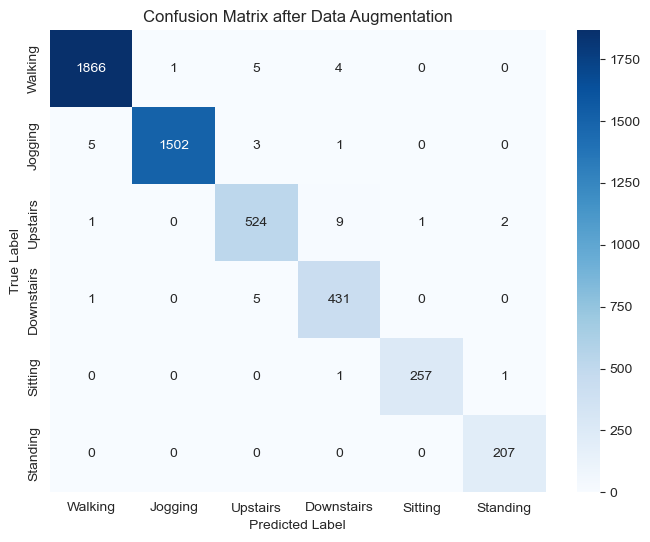

In [46]:
# Predict labels on the test set
y_pred_augmented = model.predict(X_test)
y_pred_classes_augmented = np.argmax(y_pred_augmented, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate a classification report
report_augmented = classification_report(y_true, y_pred_classes_augmented, target_names=activity_mapping.keys(), output_dict=True)
print(classification_report(y_true, y_pred_classes_augmented, target_names=activity_mapping.keys()))

# Compute the confusion matrix
cm_augmented = confusion_matrix(y_true, y_pred_classes_augmented)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_augmented, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.keys(), yticklabels=activity_mapping.keys())
plt.title('Confusion Matrix after Data Augmentation')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Observations
- **Improved Accuracy:** The test accuracy improves slightly after data augmentation, indicating better model generalization.
- **Confusion Matrix Analysis:** Fewer misclassifications between similar classes suggest that augmentation helped the model distinguish them better.


### **6.6 Visualizing Training Performance After Augmentation**

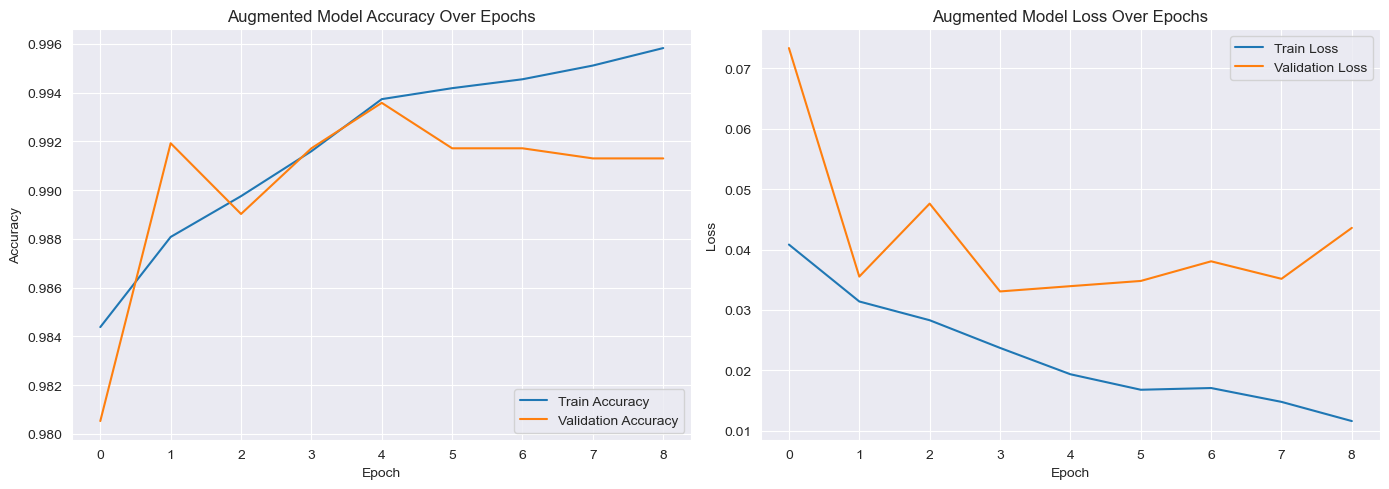

In [47]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')
plt.title('Augmented Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'], label='Train Loss')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss')
plt.title('Augmented Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Strategies to Reduce Overfitting


### **1. Increase Dropout Rates**

We'll increase the dropout rates in the model to prevent over-reliance on specific neurons.


In [48]:
# Adjust dropout rates from 0.5 to 0.7
dropout_rate = 0.7  # Increased from 0.5

# GRU layers with increased dropout
x = GRU(units=64, return_sequences=True)(x)
x = Dropout(dropout_rate)(x)
x = GRU(units=32, return_sequences=True)(x)
x = Dropout(dropout_rate)(x)

### **2. Add L2 Regularization**

Adding L2 regularization penalizes large weights, encouraging the model to keep weights small.


In [49]:
# Apply L2 regularization to the GRU layers
l2_regularization = 0.001

x = GRU(units=64, return_sequences=True, kernel_regularizer=l2(l2_regularization))(x)
x = Dropout(dropout_rate)(x)
x = GRU(units=32, return_sequences=True, kernel_regularizer=l2(l2_regularization))(x)
x = Dropout(dropout_rate)(x)

### **3. Reduce Model Complexity**

We'll reduce the number of units in the GRU layers and simplify the model architecture.

In [50]:
# Reduce the number of units
x = GRU(units=32, return_sequences=True, kernel_regularizer=l2(l2_regularization))(x)
x = Dropout(dropout_rate)(x)
x = GRU(units=16, return_sequences=True, kernel_regularizer=l2(l2_regularization))(x)
x = Dropout(dropout_rate)(x)


### **4. Implement Batch Normalization**

Adding Batch Normalization after GRU layers can help stabilize and regularize training.

In [51]:


# GRU layers with Batch Normalization
x = GRU(units=32, return_sequences=True, kernel_regularizer=l2(l2_regularization))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = GRU(units=16, return_sequences=True, kernel_regularizer=l2(l2_regularization))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

### **5. Use Learning Rate Schedules**

Implement a learning rate scheduler to adjust the learning rate during training.

In [52]:
# Define the optimizer with an initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model with the optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Define the learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [53]:

# Adjust early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

## **Updated Model Architecture**

### Combining the adjustments:

In [54]:
# Define the input layer
inputs = Input(shape=(TIME_STEPS, len(features)))

# CNN layers for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_regularization))(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# GRU layers with increased regularization
x = GRU(units=32, return_sequences=True, kernel_regularizer=l2(l2_regularization))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = GRU(units=16, return_sequences=True, kernel_regularizer=l2(l2_regularization))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

# Attention mechanism
attention_output = MultiHeadAttention(num_heads=2, key_dim=8)(x, x)
attention_output = GlobalAveragePooling1D()(attention_output)

# Output layer for classification
outputs = Dense(units=num_classes, activation='softmax')(attention_output)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with the optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 90, 3)]      0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 88, 64)       640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 88, 64)      256         ['conv1d_18[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_18 (MaxPooling1D  (None, 44, 64)      0           ['batch_normalization_3[0][

### **Training Output :**

In [56]:
# Define callbacks
callbacks = [early_stopping, reduce_lr, model_checkpoint]

# Train the model
history_updated = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict_augmented,
    callbacks=callbacks
)

Epoch 1/50
1112/1112 [==============================] - 22s 20ms/step - loss: 0.1140 - accuracy: 0.9699 - val_loss: 0.0938 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 2/50
1112/1112 [==============================] - 21s 19ms/step - loss: 0.1033 - accuracy: 0.9731 - val_loss: 0.0987 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 3/50
1112/1112 [==============================] - 21s 19ms/step - loss: 0.0936 - accuracy: 0.9763 - val_loss: 0.0936 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 4/50
1112/1112 [==============================] - 20s 18ms/step - loss: 0.0880 - accuracy: 0.9782 - val_loss: 0.1055 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 5/50
1112/1112 [==============================] - 20s 18ms/step - loss: 0.0855 - accuracy: 0.9797 - val_loss: 0.0809 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 6/50
1112/1112 [==============================] - 20s 18ms/step - loss: 0.0785 - accuracy: 0.9820 - val_loss: 0.0768 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 7/50
1112/1112 [========================

### **Evaluating the Updated Model**

In [57]:
# Evaluate the model on the test data
test_loss_updated, test_accuracy_updated = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy after Updates: {test_accuracy_updated:.4f}")

# Predict labels on the test set
y_pred_updated = model.predict(X_test)
y_pred_classes_updated = np.argmax(y_pred_updated, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate a classification report
report_updated = classification_report(y_true, y_pred_classes_updated, target_names=activity_mapping.keys(), output_dict=True)
print(classification_report(y_true, y_pred_classes_updated, target_names=activity_mapping.keys()))

Test Accuracy after Updates: 0.9909
151/151 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00      1876
     Jogging       1.00      0.99      1.00      1511
    Upstairs       0.97      0.98      0.97       537
  Downstairs       0.96      0.98      0.97       437
     Sitting       1.00      0.99      0.99       259
    Standing       0.99      1.00      0.99       207

    accuracy                           0.99      4827
   macro avg       0.99      0.99      0.99      4827
weighted avg       0.99      0.99      0.99      4827


### **Visualizing Training Performance**

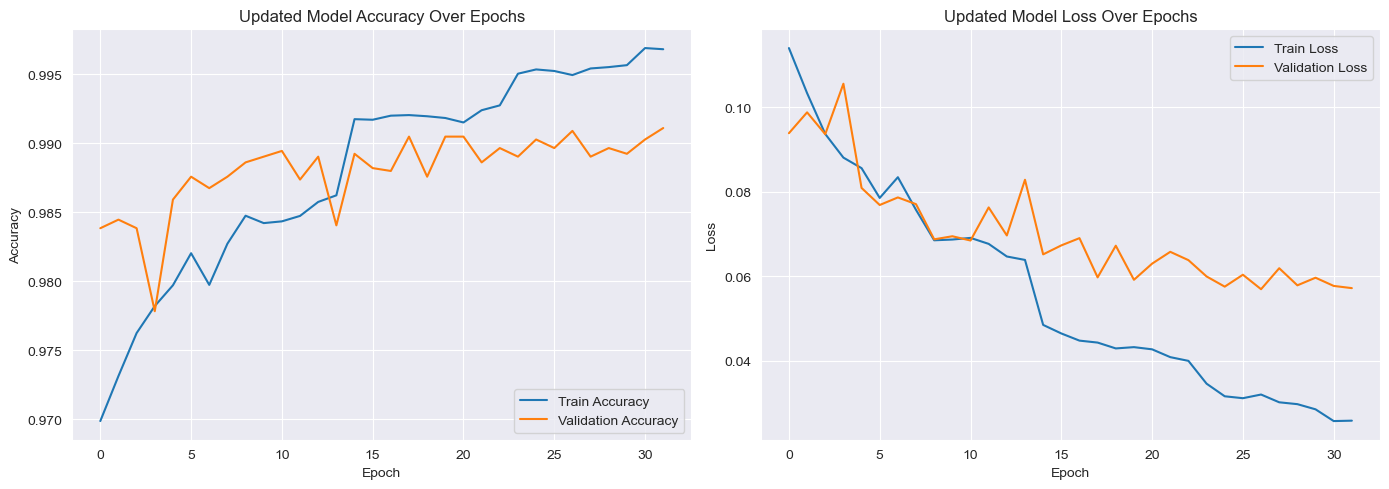

In [58]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_updated.history['accuracy'], label='Train Accuracy')
plt.plot(history_updated.history['val_accuracy'], label='Validation Accuracy')
plt.title('Updated Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_updated.history['loss'], label='Train Loss')
plt.plot(history_updated.history['val_loss'], label='Validation Loss')
plt.title('Updated Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

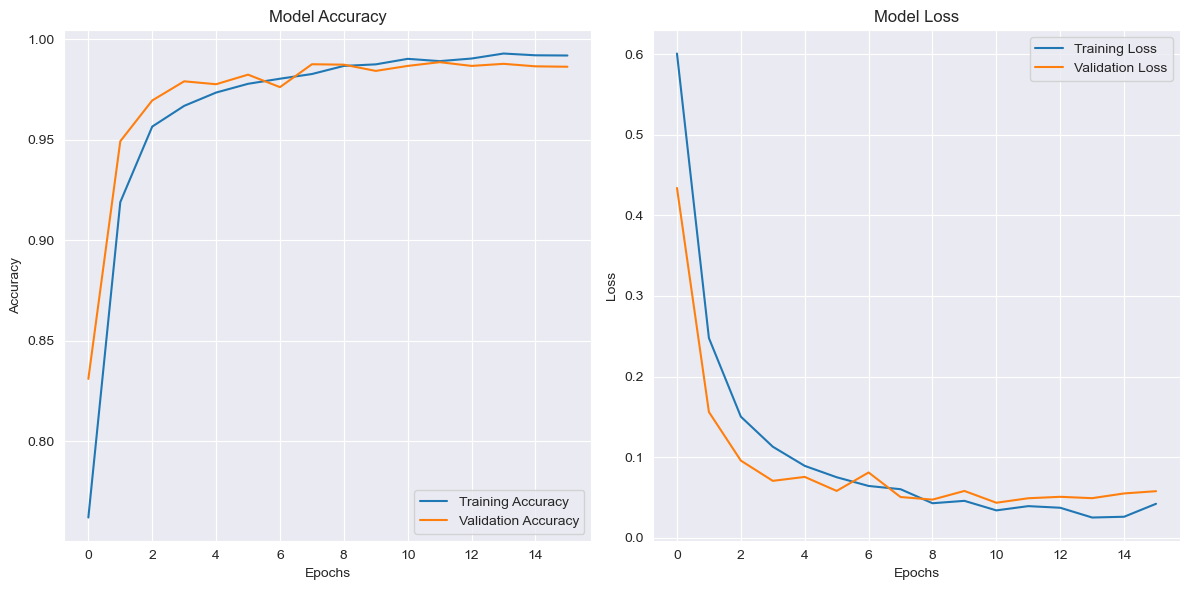

In [59]:
# Plot learning curves
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# CNN-Transformer Architecture
### Features and Enhancements:
- **Hybrid Approach**: Combines CNN's local feature extraction with the Transformer Encoder's capability for modeling long-range dependencies.
- **Regularization**: Includes dropout layers to reduce overfitting.
- **Residual Connections**: Enhances gradient flow and stabilizes training.
- **Transformer Encoder**: Captures complex relationships within the sequence, improving the model's ability to learn temporal patterns.

In [60]:
# Define the input layer
inputs = Input(shape=(TIME_STEPS, len(features)))

# CNN layers for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# Prepare for Transformer Encoder
x = Conv1D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])  # Residual connection

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, res])
    return x

# Apply the Transformer Encoder
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.5)

# Global average pooling and output
x = GlobalAveragePooling1D()(x)
outputs = Dense(units=num_classes, activation='softmax')(x)

# Define the model
model_cnn_transformer = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_cnn_transformer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display the model architecture
model_cnn_transformer.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 90, 3)]      0           []                               
                                                                                                  
 conv1d_19 (Conv1D)             (None, 88, 64)       640         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 88, 64)      256         ['conv1d_19[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_19 (MaxPooling1D  (None, 44, 64)      0           ['batch_normalization_6[0][

In [61]:
# Update ModelCheckpoint callback 
model_checkpoint.filepath = 'best_model_cnn_transformer.h5'
model_checkpoint.save_best_only = True

# Train the model
history_cnn_transformer = model_cnn_transformer.fit(
    X_train_augmented, y_train_augmented,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict_augmented,
    callbacks=callbacks
)

Epoch 1/50
1112/1112 [==============================] - 18s 14ms/step - loss: 0.3220 - accuracy: 0.8437 - val_loss: 0.2250 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 2/50
1112/1112 [==============================] - 14s 12ms/step - loss: 0.1825 - accuracy: 0.9149 - val_loss: 0.1250 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 3/50
1112/1112 [==============================] - 15s 13ms/step - loss: 0.1469 - accuracy: 0.9300 - val_loss: 0.1037 - val_accuracy: 0.9743 - lr: 0.0010
Epoch 4/50
1112/1112 [==============================] - 15s 14ms/step - loss: 0.1304 - accuracy: 0.9373 - val_loss: 0.1573 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 5/50
1112/1112 [==============================] - 14s 12ms/step - loss: 0.1201 - accuracy: 0.9428 - val_loss: 0.1039 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 6/50
1110/1112 [============================>.] - ETA: 0s - loss: 0.1102 - accuracy: 0.9486
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1112/1112 [====================

CNN-Transformer Test Accuracy: 0.9878
151/151 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

     Walking       0.99      1.00      1.00      1876
     Jogging       1.00      0.98      0.99      1511
    Upstairs       0.95      0.99      0.97       537
  Downstairs       0.97      0.96      0.96       437
     Sitting       1.00      0.99      0.99       259
    Standing       0.99      1.00      0.99       207

    accuracy                           0.99      4827
   macro avg       0.98      0.99      0.98      4827
weighted avg       0.99      0.99      0.99      4827


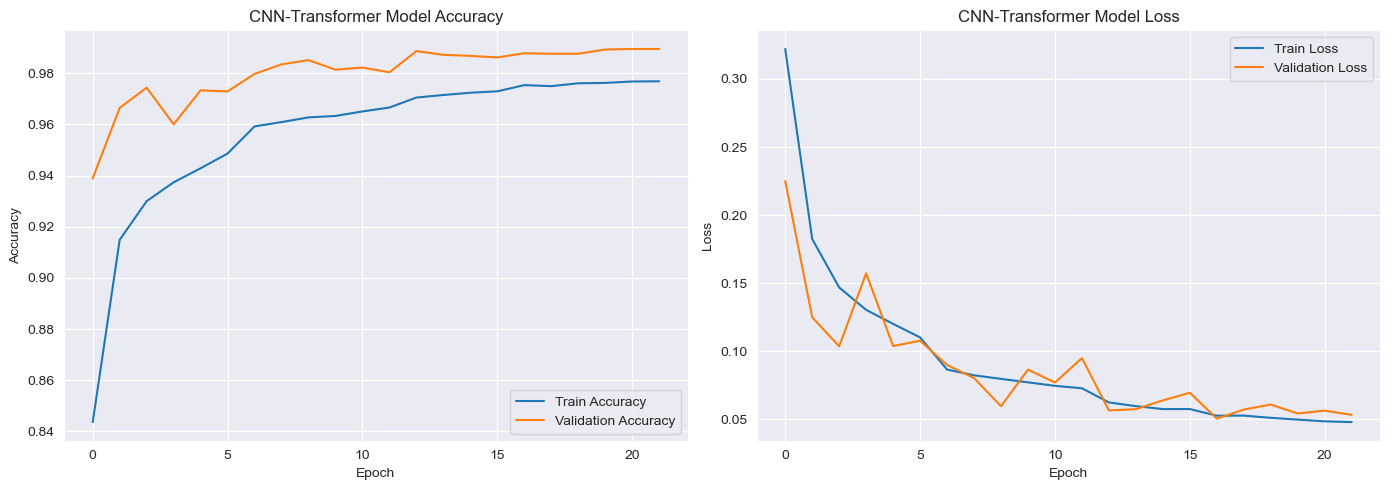

In [62]:
# Evaluate the model on the test data
test_loss_ct, test_accuracy_ct = model_cnn_transformer.evaluate(X_test, y_test, verbose=0)
print(f"CNN-Transformer Test Accuracy: {test_accuracy_ct:.4f}")

# Predict labels on the test set
y_pred_ct = model_cnn_transformer.predict(X_test)
y_pred_classes_ct = np.argmax(y_pred_ct, axis=1)

# Generate a classification report
report_ct = classification_report(y_true, y_pred_classes_ct, target_names=activity_mapping.keys())
print(report_ct)

# Plot learning curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_transformer.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_transformer.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-Transformer Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_cnn_transformer.history['loss'], label='Train Loss')
plt.plot(history_cnn_transformer.history['val_loss'], label='Validation Loss')
plt.title('CNN-Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# CNN-BiLSTM Model for Sequence Classification

- This code defines and compiles a hybrid model that combines **Convolutional Neural Networks (CNN)** for feature extraction and **Bidirectional Long Short-Term Memory (BiLSTM)** layers for sequential data modeling
- This architecture is designed for tasks like **time-series classification** or **activity recognition**, where both local patterns (CNN) and long-term dependencies (LSTM) are essential.

In [63]:
# Define the input layer
inputs = Input(shape=(TIME_STEPS, len(features)))

# CNN layers for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bidirectional LSTM layers
x = Bidirectional(LSTM(units=64, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=32))(x)
x = Dropout(0.5)(x)

# Output layer for classification
outputs = Dense(units=num_classes, activation='softmax')(x)

# Define the model
model_cnn_bilstm = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_cnn_bilstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display the model architecture
model_cnn_bilstm.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 90, 3)]           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 88, 64)            640       
                                                                 
 batch_normalization_8 (Batc  (None, 88, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 44, 64)           0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirectiona  (None, 44, 128)          66048     
 l)                                                              
                                                           

In [64]:
# Update ModelCheckpoint settings if needed
model_checkpoint.filepath = 'best_model_cnn_bilstm.h5'
model_checkpoint.monitor = 'val_loss'
model_checkpoint.save_best_only = True

# Train the model
history_cnn_bilstm = model_cnn_bilstm.fit(
    X_train_augmented, y_train_augmented,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict_augmented,
    callbacks=
    callbacks
)

Epoch 1/50
1112/1112 [==============================] - 35s 27ms/step - loss: 0.2831 - accuracy: 0.8657 - val_loss: 0.0866 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 2/50
1112/1112 [==============================] - 28s 25ms/step - loss: 0.1082 - accuracy: 0.9596 - val_loss: 0.0642 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 3/50
1112/1112 [==============================] - 28s 25ms/step - loss: 0.0672 - accuracy: 0.9751 - val_loss: 0.0479 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 4/50
1112/1112 [==============================] - 28s 25ms/step - loss: 0.0507 - accuracy: 0.9821 - val_loss: 0.0356 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 5/50
1112/1112 [==============================] - 29s 26ms/step - loss: 0.0400 - accuracy: 0.9864 - val_loss: 0.0317 - val_accuracy: 0.9913 - lr: 0.0010
Epoch 6/50
1112/1112 [==============================] - 28s 25ms/step - loss: 0.0312 - accuracy: 0.9897 - val_loss: 0.0304 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 7/50
1112/1112 [========================

CNN-Bidirectional LSTM Test Accuracy: 0.9944
151/151 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00      1876
     Jogging       1.00      1.00      1.00      1511
    Upstairs       0.98      0.98      0.98       537
  Downstairs       0.99      0.99      0.99       437
     Sitting       1.00      0.98      0.99       259
    Standing       0.98      1.00      0.99       207

    accuracy                           0.99      4827
   macro avg       0.99      0.99      0.99      4827
weighted avg       0.99      0.99      0.99      4827


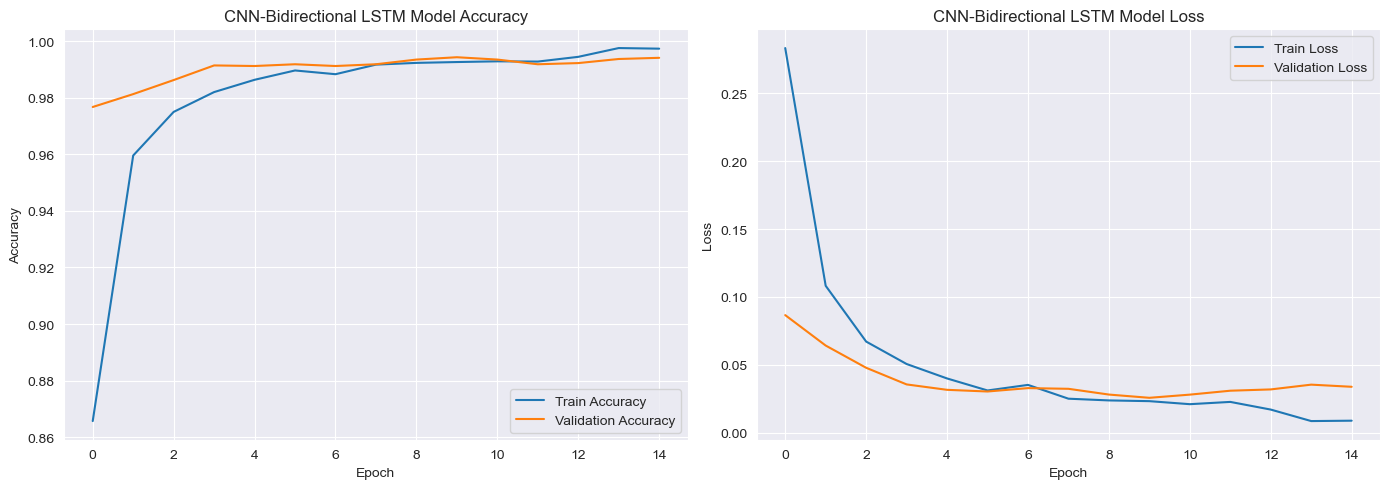

In [65]:
# Evaluate the model on the test data
test_loss_cbl, test_accuracy_cbl = model_cnn_bilstm.evaluate(X_test, y_test, verbose=0)
print(f"CNN-Bidirectional LSTM Test Accuracy: {test_accuracy_cbl:.4f}")

# Predict labels on the test set
y_pred_cbl = model_cnn_bilstm.predict(X_test)
y_pred_classes_cbl = np.argmax(y_pred_cbl, axis=1)

# Generate a classification report
report_cbl = classification_report(y_true, y_pred_classes_cbl, target_names=activity_mapping.keys())
print(report_cbl)

# Plot learning curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_bilstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-Bidirectional LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_cnn_bilstm.history['loss'], label='Train Loss')
plt.plot(history_cnn_bilstm.history['val_loss'], label='Validation Loss')
plt.title('CNN-Bidirectional LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [66]:
print(f"CNN-GRU-Attention Model Test Accuracy: {test_accuracy_augmented:.4f}")
print(f"CNN-Transformer Model Test Accuracy: {test_accuracy_ct:.4f}")
print(f"CNN-Bidirectional LSTM Model Test Accuracy: {test_accuracy_cbl:.4f}")

CNN-GRU-Attention Model Test Accuracy: 0.9917
CNN-Transformer Model Test Accuracy: 0.9878
CNN-Bidirectional LSTM Model Test Accuracy: 0.9944


# CNN-BiLSTM with Attention Mechanism

1. **Added Attention Layer**: Captures long-range dependencies.
2. **Residual Connections**: Improve gradient flow and model stability.
3. **Layer Normalization**: Enhances stability during training.
4. **L2 Regularization**: Reduces overfitting by penalizing large weights.
5. **Increased Dropout Rate**: Stronger regularization.

In [71]:
# Define the enhanced input layer
inputs = Input(shape=(TIME_STEPS, len(features)))

# CNN layers for feature extraction with L2 regularization
x = Conv1D(
    filters=64,
    kernel_size=3,
    activation='relu',
    kernel_regularizer=l2(0.001)
)(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# First Bidirectional LSTM layer with residual connection
x = Bidirectional(
    LSTM(
        units=64,
        return_sequences=True,
        kernel_regularizer=l2(0.001)
    )
)(x)
x = Dropout(0.6)(x)

# Second Bidirectional LSTM layer
x = Bidirectional(
    LSTM(
        units=32,
        return_sequences=True,
        kernel_regularizer=l2(0.001)
    )
)(x)
x = Dropout(0.6)(x)

# Residual connection after LSTM layers
residual = x  # Store the output for residual connection
x = Bidirectional(
    LSTM(
        units=32,
        return_sequences=True,
        kernel_regularizer=l2(0.001)
    )
)(x)
x = Dropout(0.6)(x)
x = Add()([residual, x])  # Residual connection
x = LayerNormalization()(x)  # Layer normalization after residual

# Attention mechanism with residual connection
attn_output = MultiHeadAttention(
    num_heads=4,
    key_dim=32,
    dropout=0.3
)(x, x)
attn_output = Dropout(0.6)(attn_output)
x = Add()([x, attn_output])  # Residual connection
x = LayerNormalization()(x)  # Layer normalization after residual

# Global average pooling and output layer
x = GlobalAveragePooling1D()(x)
outputs = Dense(
    units=num_classes,
    activation='softmax',
    kernel_regularizer=l2(0.001)
)(x)

# Define the model
enhanced_model_cnn_bilstm = Model(inputs=inputs, outputs=outputs)

# Compile the model with optimized learning rate
optimizer = Adam(learning_rate=0.001)
enhanced_model_cnn_bilstm.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Display the model architecture
enhanced_model_cnn_bilstm.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 90, 3)]      0           []                               
                                                                                                  
 conv1d_23 (Conv1D)             (None, 88, 64)       640         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 88, 64)      256         ['conv1d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling1d_22 (MaxPooling1D  (None, 44, 64)      0           ['batch_normalization_10[0]

In [72]:
# Define callbacks
early_stopping_enhanced = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
model_checkpoint_enhanced = ModelCheckpoint(
    'best_model_cnn_bilstm_enhanced.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)
reduce_lr_enhanced = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Combine all callbacks
callbacks_enhanced = [
    early_stopping_enhanced,
    model_checkpoint_enhanced,
    reduce_lr_enhanced
]

In [73]:
# Train the enhanced model
history_enhanced = enhanced_model_cnn_bilstm.fit(
    X_train_augmented, y_train_augmented,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict_augmented,
    callbacks=callbacks_enhanced
)

Epoch 1/50
1111/1112 [============================>.] - ETA: 0s - loss: 0.4707 - accuracy: 0.9015
Epoch 1: val_loss improved from inf to 0.23733, saving model to best_model_cnn_bilstm_enhanced.h5
1112/1112 [==============================] - 53s 40ms/step - loss: 0.4706 - accuracy: 0.9015 - val_loss: 0.2373 - val_accuracy: 0.9743 - lr: 0.0010
Epoch 2/50
1112/1112 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9630
Epoch 2: val_loss improved from 0.23733 to 0.15109, saving model to best_model_cnn_bilstm_enhanced.h5
1112/1112 [==============================] - 42s 38ms/step - loss: 0.2064 - accuracy: 0.9630 - val_loss: 0.1511 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 3/50
1111/1112 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9730
Epoch 3: val_loss did not improve from 0.15109
1112/1112 [==============================] - 41s 37ms/step - loss: 0.1531 - accuracy: 0.9730 - val_loss: 0.6414 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 4/50
1111

In [74]:
# Evaluate the model on the test data
test_loss_enhanced, test_accuracy_enhanced = enhanced_model_cnn_bilstm.evaluate(X_test, y_test, verbose=0)
print(f"Enhanced CNN-Bidirectional LSTM Test Accuracy: {test_accuracy_enhanced:.4f}")

Enhanced CNN-Bidirectional LSTM Test Accuracy: 0.9956


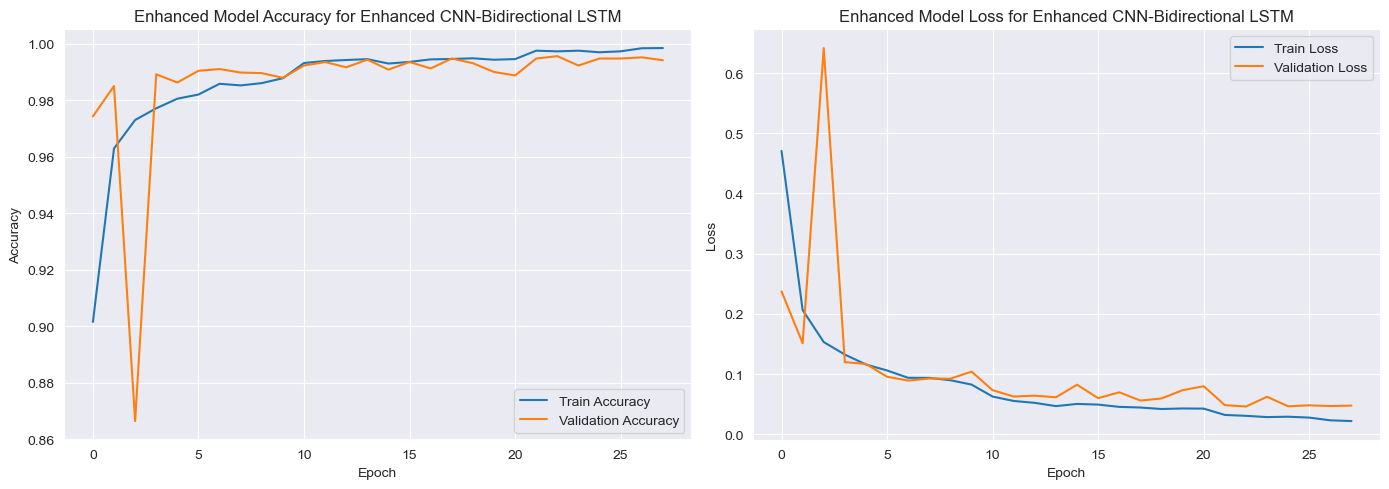

In [75]:
def plot_learning_curves(history, title_suffix=''):
    plt.figure(figsize=(14, 5))
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Enhanced Model Accuracy {title_suffix}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Enhanced Model Loss {title_suffix}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot learning curves for the enhanced model
plot_learning_curves(history_enhanced, 'for Enhanced CNN-Bidirectional LSTM')


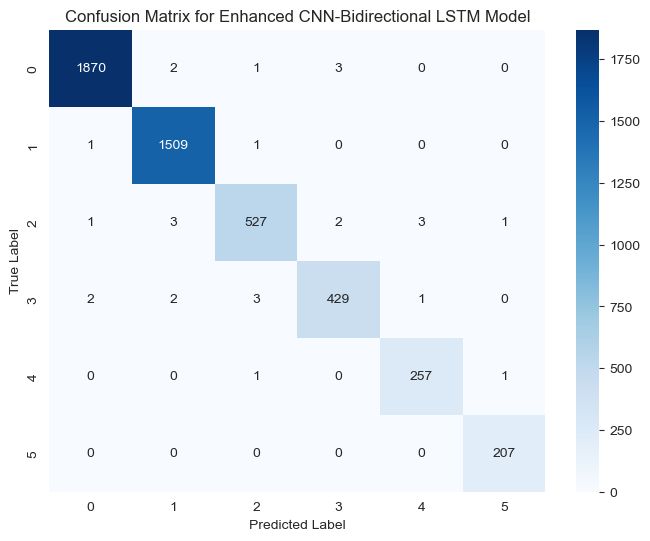

In [76]:

# Compute the confusion matrix
cm_enhanced = confusion_matrix(y_true, y_pred_classes_enhanced)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_enhanced, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_mapping.values(),
            yticklabels=activity_mapping.values())
plt.title('Confusion Matrix for Enhanced CNN-Bidirectional LSTM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


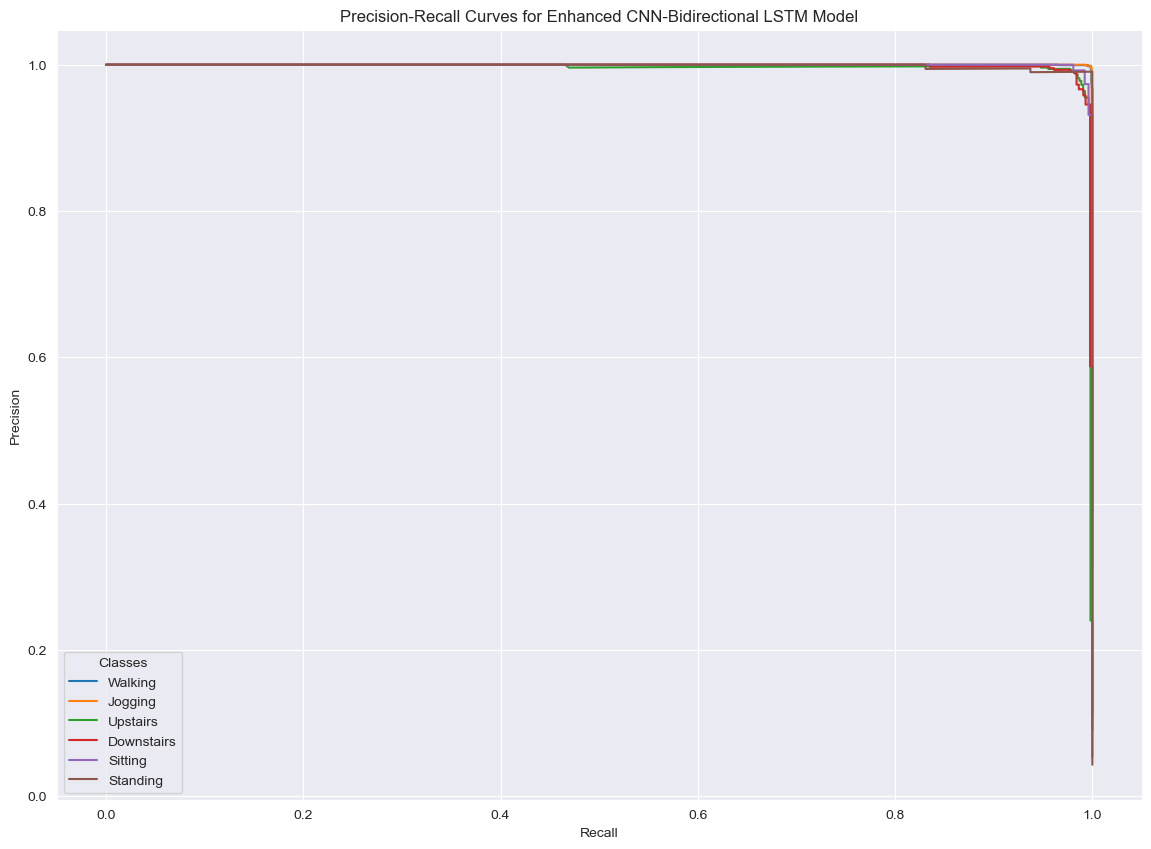

In [81]:
# Explicitly define class names
class_names = ["Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing"]

def plot_precision_recall_curves(y_true, y_pred, class_names, title='Precision-Recall Curves'):

    plt.figure(figsize=(14, 10))
    for i, class_name in enumerate(class_names):
        # Binarize y_true for the current class
        y_true_binary = (y_true == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_true_binary, y_pred[:, i])
        plt.plot(recall, precision, label=class_name)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(title="Classes", loc='lower left')
    plt.show()

plot_precision_recall_curves(
    y_true=y_true,
    y_pred=y_pred_enhanced,
    class_names=class_names,  # Use explicitly defined class names
    title='Precision-Recall Curves for Enhanced CNN-Bidirectional LSTM Model'
)

In [82]:
print(f"CNN-GRU-Attention Model Test Accuracy: {test_accuracy_augmented:.4f}")
print(f"CNN-Transformer Model Test Accuracy: {test_accuracy_ct:.4f}")
print(f"CNN-Bidirectional LSTM Model Test Accuracy: {test_accuracy_cbl:.4f}")
print(f"Enhanced CNN-Bidirectional LSTM Test Accuracy: {test_accuracy_enhanced:.4f}")

CNN-GRU-Attention Model Test Accuracy: 0.9917
CNN-Transformer Model Test Accuracy: 0.9878
CNN-Bidirectional LSTM Model Test Accuracy: 0.9944
Enhanced CNN-Bidirectional LSTM Test Accuracy: 0.9956
